<a href="https://colab.research.google.com/github/TheArmbreaker/Object-Detection-Air-Base-Military-Equipment/blob/main/Deployment_SAHI_plotly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deployment - Improved Small Object Detection

In [1]:
! git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 14717, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 14717 (delta 19), reused 18 (delta 7), pack-reused 14677
Receiving objects: 100% (14717/14717), 13.54 MiB | 17.98 MiB/s, done.
Resolving deltas: 100% (10161/10161), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd yolov5
%pip install -qr requirements.txt
!pip install -U sahi yolov5

/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import sys
import cv2
from PIL import Image as Img
from IPython.display import Image, display, HTML

from sahi.utils.yolov5 import ( 
    download_yolov5s6_model,
)

# import required functions, classes
from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict

import shutil
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import init_notebook_mode

In [20]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

## Slicing Aided Hyper Inference

Slicing Aided Hyper Inference (SAHI) ist eine Python-Bibliothek die das Problem der Small Objects Detection auf großen Bildern zu lösen versucht. 
Dies erfolgt über eine Sliced Prediction, also eine Prediction auf Tiles. Dabei werden jedoch doppelte Zählunge von erkannten Objekten vermieden. {cite:p}`obss2021sahi`

Nachfolgend werden die Gewichte des besten Modells geladen und auf die Bilder aus dem Proof of Concept angewendet. Der Barplot zeigt, dass deutlich mehr Fluggerät erkannt wurde - auch für die anderen Flugplätze.

SAHI bietet unterschiedliche Methoden für den Zugriff auf die Ergebnisse. Mit to_coco_predictions(image_id) können Listen mit Dictionary je Detektion abgerufen werden. Dies ermöglicht das Erstellen des Barplots aus dem Proof of Concept.

In [3]:
yolov5_model_path = '/content/drive/MyDrive/dataset/colab_exports/Zeile31_XLmod_Background_Tiled_TrainingData2/weights/best.pt'
_images = list()
_images.append("/content/drive/MyDrive/dataset/tests/MCAS_Iwakuni_1_100m.png")
_images.append("/content/drive/MyDrive/dataset/tests/MCAS_Iwakuni_2_100m.png")
_images.append("/content/drive/MyDrive/dataset/tests/RUS_Severomorsk.jpg")
_images.append("/content/drive/MyDrive/dataset/tests/DEU_Ansbach_Katterbach.jpg")


In [4]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov5',
    model_path=yolov5_model_path,
    confidence_threshold=0.4,
    #device="cpu",
    device="cuda:0"
)

````{margin}
```{note}
Lt. SAHI Beispielen sollte die image_id je Dictionary über das Auslesen eines Image Directory erzeugt werden. Dies lies sich noch nicht erfolgreich umsetzen. Daher werden die Predictions über eine Schleife erzeugt und die image_ids manuell ergänzt.
```
````


In [5]:
result_list = list()
for image in _images: 
  results = get_sliced_prediction(
        image,
        detection_model,
        slice_height = 256,
        slice_width = 256,
        overlap_height_ratio = 0.2,
        overlap_width_ratio = 0.2
        )
  loc = image.split("/")[-1].split(".")[0]
  result_list_cache = results.to_coco_annotations()
  results.export_visuals(export_dir=f'/content/drive/MyDrive/dataset/tests/sahi_exp/{loc}')
  for i in result_list_cache:
    i['image_id'] = loc
  result_list.extend(result_list_cache)

Performing prediction on 50 number of slices.
Performing prediction on 50 number of slices.
Performing prediction on 414 number of slices.
Performing prediction on 120 number of slices.


In [6]:
df = pd.DataFrame.from_dict(result_list)

In [7]:
df.tail()

image_id                                               bbox  \
70  DEU_Ansbach_Katterbach  [504.81485748291016, 1118.430519104004, 46.627...   
71  DEU_Ansbach_Katterbach  [178.6126708984375, 1426.4920501708984, 53.600...   
72  DEU_Ansbach_Katterbach  [255.3604393005371, 1440.1481018066406, 56.805...   
73  DEU_Ansbach_Katterbach  [257.0429878234863, 1410.9247741699219, 53.042...   
74  DEU_Ansbach_Katterbach  [205.39718171954155, 1427.8233489990234, 21.20...   

       score  category_id category_name segmentation  iscrowd  area  
70  0.781747            1    helicopter           []        0  1504  
71  0.776490            1    helicopter           []        0  4044  
72  0.575088            1    helicopter           []        0  2839  
73  0.514110            1    helicopter           []        0  2641  
74  0.449921            1    helicopter           []        0   957

In [8]:
# Zusätzlicher Screenshot für Iwakuni
df['location'] = np.where(df['image_id'].str.contains('100m'),'MCAS_Iwakuni',df['image_id'])
df['location'] = df['location'].str.replace('_',' ')

In [21]:
configure_plotly_browser_state()
init_notebook_mode(False) # To show plotly plots when notebook is exported to html
fig = px.bar(
    df.groupby(['location','category_name']).count().reset_index(),
    x='location',
    y='category_id',
    color='category_name',
    barmode='group'
    )
fig.update_layout(
    xaxis_title="Standorte",
    yaxis_title="Anzahl",
    legend_title="Kategorie",
    title='Anzahl an Fluggerät nach Standort und Kategorie'
)
newnames = {'plane':'Flugzeuge', 'helicopter': 'Helikopter'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                    )
fig.show()

```{glue:figure} boot_fig_sahi1
:name: "depl_sahi_barplot"

Eigene Darstellung: Barplot Anzahl Detektionen mit SAHI
```

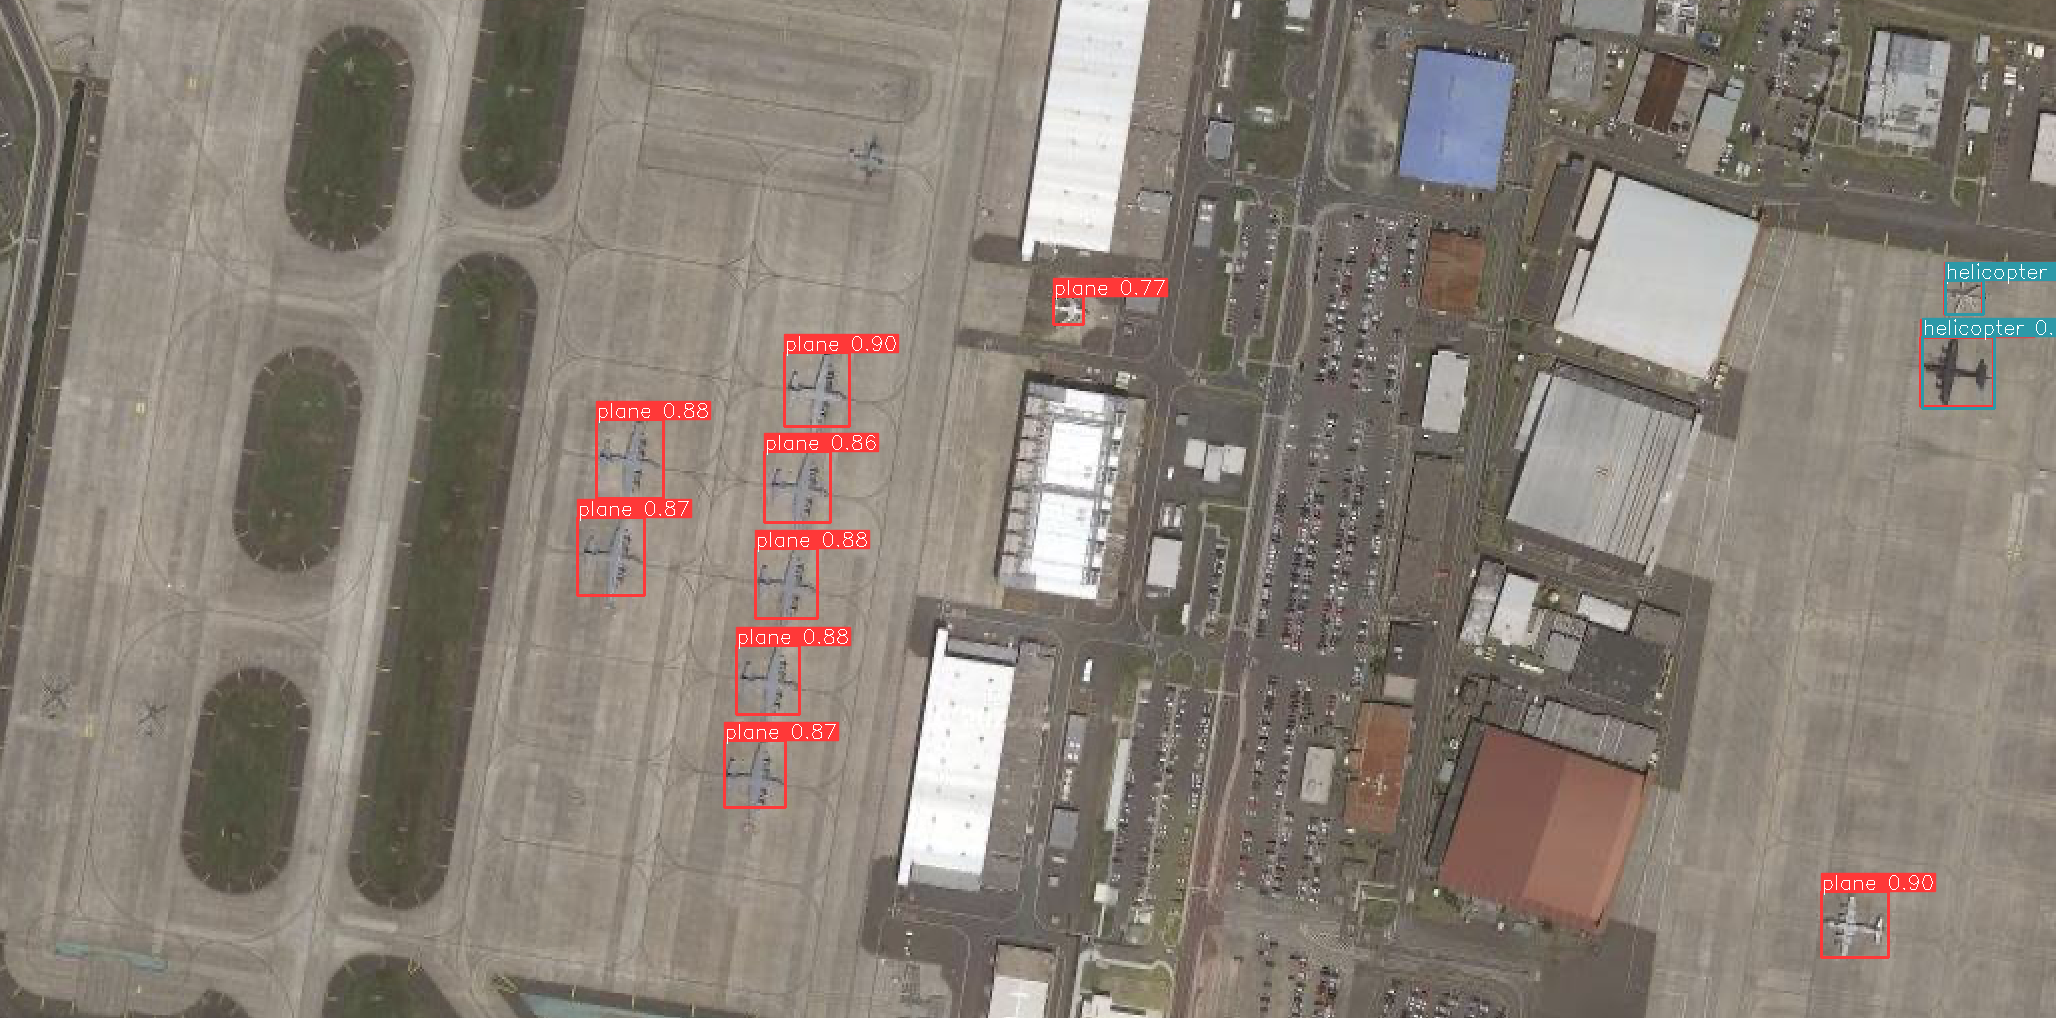

In [10]:
Image("/content/drive/MyDrive/dataset/tests/sahi_exp/MCAS_Iwakuni_1_100m/prediction_visual.png")

Kartendaten Copyright 2022: Google  
Bilder Copyright 2022: CNES / Airbus, Maxer Technologies, Planet.com

```{glue:figure} boot_fig_sahi2
:name: "depl_sahi_output"

Output zu MCAS Iwakuni Bild 1 (100m)
```

In [11]:
df[df['image_id']=='MCAS_Iwakuni_1_100m']

image_id                                               bbox  \
0   MCAS_Iwakuni_1_100m  [784.9304809570312, 352.1981506347656, 64.6701...   
1   MCAS_Iwakuni_1_100m  [1821.3680515289307, 891.7122192382812, 66.797...   
2   MCAS_Iwakuni_1_100m  [736.2460327148438, 645.2518920898438, 63.1655...   
3   MCAS_Iwakuni_1_100m  [596.0985717773438, 419.3920593261719, 67.4025...   
4   MCAS_Iwakuni_1_100m  [755.6351928710938, 548.8868408203125, 61.5064...   
5   MCAS_Iwakuni_1_100m  [577.803466796875, 517.09912109375, 66.5289916...   
6   MCAS_Iwakuni_1_100m  [724.25537109375, 740.0423583984375, 61.101623...   
7   MCAS_Iwakuni_1_100m  [764.1305541992188, 451.3215637207031, 66.4436...   
8   MCAS_Iwakuni_1_100m  [1053.2021484375, 296.310791015625, 30.7189941...   
9   MCAS_Iwakuni_1_100m  [1920.8675537109375, 337.9620361328125, 73.077...   
10  MCAS_Iwakuni_1_100m  [1944.7564697265625, 280.8858947753906, 37.818...   
11  MCAS_Iwakuni_1_100m  [1945.3134765625, 280.3576354980469, 38.140258...   
12  MCAS_Iwakuni_1_100m  [1922.3946533203125, 336.11224365234375, 72.19...   

       score  category_id category_name segmentation  iscrowd  area  \
0   0.899122            0         plane           []        0  4819   
1   0.897323            0         plane           []        0  4421   
2   0.884831            0         plane           []        0  4391   
3   0.884480            0         plane           []        0  5336   
4   0.878369            0         plane           []        0  4277   
5   0.872563            0         plane           []        0  5247   
6   0.871069            0         plane           []        0  4143   
7   0.864177            0         plane           []        0  4711   
8   0.774200            0         plane           []        0   865   
9   0.764337            0         plane           []        0  5003   
10  0.468951            0         plane           []        0  1270   
11  0.511455            1    helicopter           []        0  1293   
12  0.454081            1    helicopter           []        0  5241   

        location  
0   MCAS Iwakuni  
1   MCAS Iwakuni  
2   MCAS Iwakuni  
3   MCAS Iwakuni  
4   MCAS Iwakuni  
5   MCAS Iwakuni  
6   MCAS Iwakuni  
7   MCAS Iwakuni  
8   MCAS Iwakuni  
9   MCAS Iwakuni  
10  MCAS Iwakuni  
11  MCAS Iwakuni  
12  MCAS Iwakuni